# Bitcoin Battle Royale - Getting started (Python 2 notebook)

Welcome to Bitcoin Battle Royale, a contest where you have the predict the probability of bitcoin moving more than 0.25% over the next 30min.

This notebook aims to provide a few code snippets you can use to download data from s3, and also a few ways to interact with the feature set.

You don't have to use any of this code, this should only be considered as a quick start guide...

If you have any questions, ask Eben or Mike :)

## How to download data from S3

This notebook references a config.ini file in the config folder. You should enter your AWS access key and secret key in the config.ini file. If you wanted to use ConfigParser to load your credentials, this is what it would look like:

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.graphics.tsaplots as tsa

C:\Anaconda2\envs\py3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [1]:
import configparser, os

Config = configparser.ConfigParser(allow_no_value=True)
Config.read(os.path.join(os.path.dirname(os.getcwd()), 'config', 'config.ini'))

aws_access_key_id = Config.get("aws_credentials", "aws_access_key_id")
aws_secret_access_key = Config.get("aws_credentials", "aws_secret_access_key")
bucket_name_value = Config.get("aws_credentials", "bucket_name_value")

To download data, we're going to create a download folder on our local machine...

In [2]:
download_folder = os.path.join(os.path.dirname(os.getcwd()), 'data')
if not os.path.exists(download_folder):
    os.makedirs(download_folder)
    print("Created download folder", download_folder)
else:
    print("Download folder already exists", download_folder)

Download folder already exists C:\Users\Brad Deutsch\Documents\Projects\btc_battle\data


Great! Now we're ready to download data from s3.
The following function makes it easy to list all the bitcoin files available for download in our s3 bucket...

In [3]:
import boto
from boto.s3.key import Key
from boto.s3.connection import OrdinaryCallingFormat

def download_most_recent_tick_data_files(download_destination=download_folder,
                                         number_of_files_to_download=5):
    
    # establish a connection using our access keys...
    conn = boto.connect_s3(aws_access_key_id,
                           aws_secret_access_key,
                           calling_format=OrdinaryCallingFormat())
    # connect to our bucket...
    bucket = conn.get_bucket(bucket_name_value)

    # connect to the folder that contains all the bitcoin trading data...
    most_recent_files = sorted([k.key for k in boto.s3.bucketlistresultset.bucket_lister(bucket,
                                                                                         prefix="featuredata/GDAX/")],
                               reverse=True)[0:int(number_of_files_to_download)]
    for most_recent_file_key in most_recent_files:
        k = Key(bucket, most_recent_file_key)
        k.get_contents_to_filename(os.path.join(download_destination,
                                                most_recent_file_key.split("/")[-1]))
        print("Downloaded to local...", most_recent_file_key)

# call the function...
download_most_recent_tick_data_files()

('Downloaded to local...', u'featuredata/GDAX/2018-04-25-GDAX.finalfeatures.csv')
('Downloaded to local...', u'featuredata/GDAX/2018-04-24-GDAX.finalfeatures.csv')
('Downloaded to local...', u'featuredata/GDAX/2018-04-23-GDAX.finalfeatures.csv')
('Downloaded to local...', u'featuredata/GDAX/2018-04-22-GDAX.finalfeatures.csv')
('Downloaded to local...', u'featuredata/GDAX/2018-04-21-GDAX.finalfeatures.csv')


## Quick description of features...

In [5]:
import pandas as pd

# pick the most recent file for analysis...
most_recent_tick_data_file = os.path.join(download_folder,
                                          sorted(os.listdir(download_folder), reverse=True)[0])
data_df = pd.read_csv(most_recent_tick_data_file)
print(most_recent_tick_data_file, "df loaded, shape", data_df.shape)

C:\Users\Brad Deutsch\Documents\Projects\btc_battle\data\2017-12-16-GDAX.finalfeatures.csv df loaded, shape (60761, 115)


Plot of prices

In [6]:
# convert times to datetimes
data_df['time'] = pd.to_datetime(data_df['time'])

In [20]:
from datetime import timedelta

def hhmax(row):         
    ser = data_df['price'][(data_df['time'] > row) &
               (data_df['time'] <= row + timedelta(minutes=30))]
    return ser.max()

data_df['MaxY'] = data_df['time'].apply(hhmax)


,Unnamed: 0,last_size,price,side,time,price_spread,min_price,max_price,min_volume,max_volume,...,7th_larg_order_10_rar,7th_larg_order_100_rar,7th_larg_order_1000_rar,8th_larg_order_10_rar,8th_larg_order_100_rar,8th_larg_order_1000_rar,9th_larg_order_10_rar,9th_larg_order_100_rar,9th_larg_order_1000_rar,MaxY
0,5,0.025900,17726.10,buy,2017-12-16 05:00:48.744,1.043659,0.0,1.043659,0.0,3.3325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17790.0
1,6,0.007548,17726.09,sell,2017-12-16 05:00:52.875,1.043659,0.0,1.043659,0.0,3.3325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17790.0
2,7,0.260831,17726.09,sell,2017-12-16 05:00:52.875,1.043659,0.0,1.043659,0.0,3.3325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17790.0
3,8,0.110043,17726.10,buy,2017-12-16 05:00:53.748,1.170000,0.0,1.170000,0.0,3.3325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17790.0
4,9,0.020030,17726.10,buy,2017-12-16 05:00:53.876,1.170000,0.0,1.170000,0.0,3.3325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17790.0


In [29]:
from datetime import timedelta
import numpy as np

def hhmax(row):         
    ser = data_df['price'][(data_df['time'] > row) &
               (data_df['time'] <= row + timedelta(minutes=30))]
    
    minY = np.min(ser)
    maxY = np.max(ser)
    currentY = ser[0]
    
    thresh_low = currentY * (1 - 0.0025)
    thres_hi = currentY * (1 + 0.0025)
    
    exceeds_low == minY <= thresh_low
    exceeds_hi == maxY >= thresh_hi
    
    if (not exceeds_low) and (not exceeds_hi):
        target = 0
    elif (exceeds_low) and (not exceeds_hi):
        target = 1
    elif (not exceeds_low) and (exceeds_hi):
        target = 2
    else: 
        target = 3
                    
    return target

data_df['MinY'] = data_df['time'].apply(hhmax)


KeyError: 0

In [24]:
if 1==0:
    a = 1
elif 1 == 1:
    a = 2

In [7]:
# define plotting function

def tsplot2(y, title, lags=None, figsize=(12, 8)):
    """
    Credit to Jeffrey Yau, PyData NYC 2017, "Time Series Forecasting using Statistical and Machine Learning Models"
    Examine the patterns of  ACF and PACF, along with the time series plot and histogram.
    :param y:
    :param title:
    :param lags:
    :param figsize:
    :return:
    """

    fig = plt.figure(figsize=figsize)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout,  (0,0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=14, fontweight='bold')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    tsa.plot_acf(y, lags=lags, ax=acf_ax)
    tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

In [32]:
data = pd.read_csv('target_test.csv')

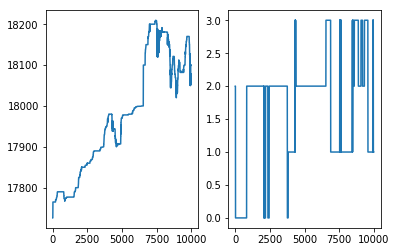

In [43]:
layout = (1,2)
price_ax = plt.subplot2grid(layout,  (0,0))
target_ax = plt.subplot2grid(layout,  (0,1))


data['price'][:10000].plot(ax=price_ax)
data['target'][:10000].plot(ax=target_ax)

(<matplotlib.axes._subplots.AxesSubplot at 0x2e17210>,
 <matplotlib.axes._subplots.AxesSubplot at 0x19b53710>)

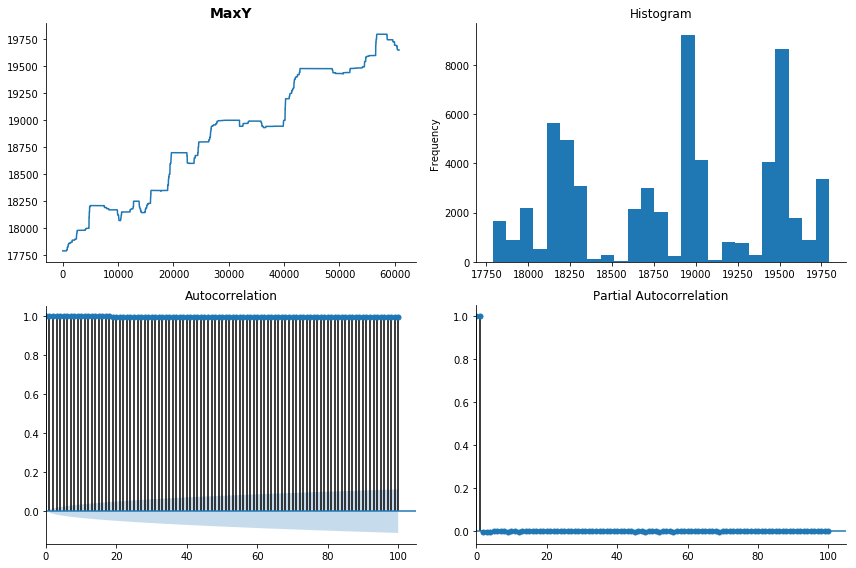

In [21]:
# for each series, plot a time series, histogram, autocorr, and partial autocorr
tsplot2(data_df['target'].dropna(), title='MaxY', lags=100)

In [11]:
# we could just dump all the feature names in alphabetical order...
for feature in sorted(data_df.columns.values):
    print(feature)

0th_larg_order
0th_larg_order_1000_rar
0th_larg_order_100_rar
0th_larg_order_10_rar
1th_larg_order
1th_larg_order_1000_rar
1th_larg_order_100_rar
1th_larg_order_10_rar
2th_larg_order
2th_larg_order_1000_rar
2th_larg_order_100_rar
2th_larg_order_10_rar
3th_larg_order
3th_larg_order_1000_rar
3th_larg_order_100_rar
3th_larg_order_10_rar
4th_larg_order
4th_larg_order_1000_rar
4th_larg_order_100_rar
4th_larg_order_10_rar
5th_larg_order
5th_larg_order_1000_rar
5th_larg_order_100_rar
5th_larg_order_10_rar
6th_larg_order
6th_larg_order_1000_rar
6th_larg_order_100_rar
6th_larg_order_10_rar
7th_larg_order
7th_larg_order_1000_rar
7th_larg_order_100_rar
7th_larg_order_10_rar
8th_larg_order
8th_larg_order_1000_rar
8th_larg_order_100_rar
8th_larg_order_10_rar
9th_larg_order
9th_larg_order_1000_rar
9th_larg_order_100_rar
9th_larg_order_10_rar
Unnamed: 0
last_size
last_size_1000_rar
last_size_100_rar
last_size_10_rar
max_price
max_price_1000_rar
max_price_100_rar
max_price_10_rar
max_volume
max_volume

Key points:

1. Whenever you see a _rar value, remember that it refers to rolling average return by time, e.g. 10m = 10 minutes, 1m = 1 minute, 60m = an hour...
2. "larg_order" features refer to the orderbook on GDAX, largest orders, already normalized
3. "last_size" refers to the size of the most recent trade in BTC
4. "max_price", "min_price", "std_price", "max_volume", "mean_price" etc. all refers to statistical properties of recent price and volume trends
5. "side" is a variable that shows if the recent trade was a buy order or a sell order...
6. "time" is the UTC timestamp of the trade
7. "volume_over_price" and "volume_under_price" - ?
8. "vwp" refers to volume weighted price

## Display plots for feature interaction

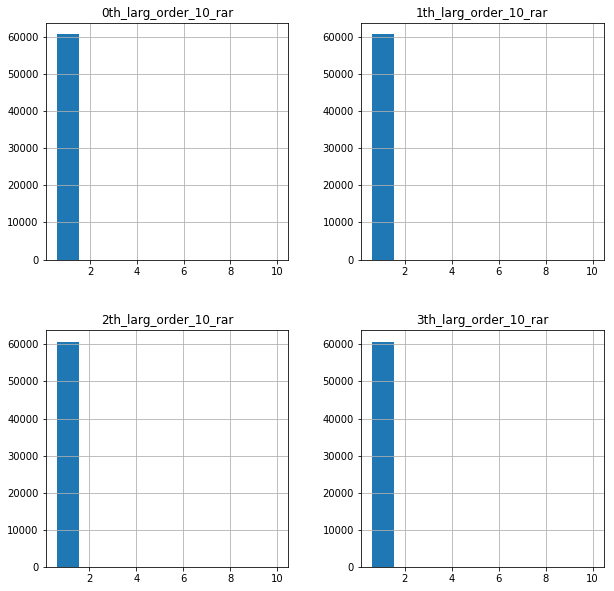

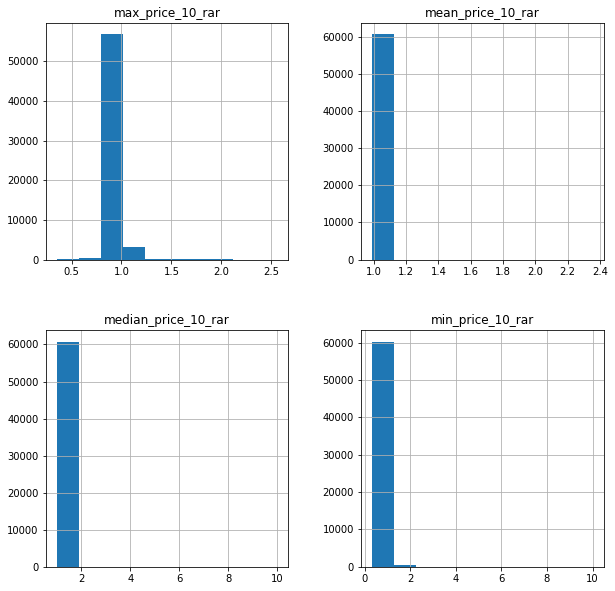

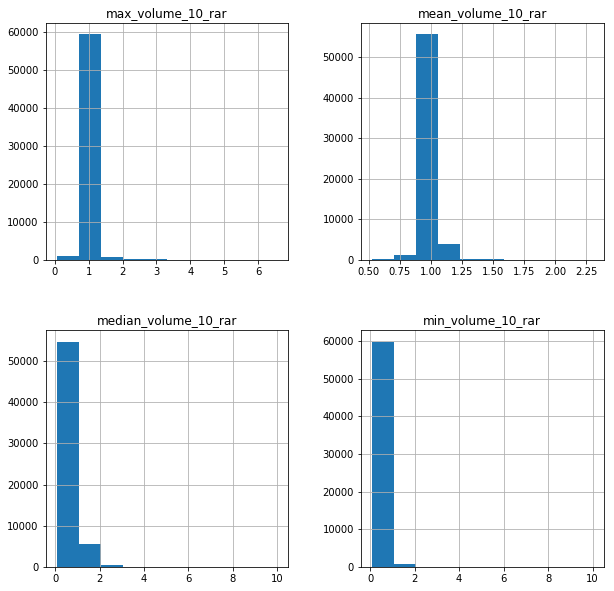

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

feature_categories_to_plot = ["_larg_order_10_rar", "_price_10_rar", "_volume_10_rar"]

for feature_category in feature_categories_to_plot:
    features_to_scan = sorted([h for h in data_df.columns.values if h.find(feature_category) != -1])[0:4]
    data_df[features_to_scan].hist()

...notice how very few of these features look like they have a "normal" distribution...this is likely due to the impact of outliers...

One quick and easy way to filter for outliers is to simply remove the bottom x% and the top x% of a feature set...

0th_larg_order_10_rar lower_bound 0.9971569089246036 upper_bound 1.0024794302955753
1th_larg_order_10_rar lower_bound 0.9969833619902206 upper_bound 1.0026856733840153
2th_larg_order_10_rar lower_bound 0.9968603966163302 upper_bound 1.002747928747032
3th_larg_order_10_rar lower_bound 0.9969098925920975 upper_bound 1.0029048563530218
max_price_10_rar lower_bound 0.9997055301039836 upper_bound 1.0003891749613536
mean_price_10_rar lower_bound 0.9995471915642389 upper_bound 1.0004578889074345
median_price_10_rar lower_bound 0.9998587127090175 upper_bound 1.0001274180400426
min_price_10_rar lower_bound 0.9993953249964678 upper_bound 1.0002971620975274
max_volume_10_rar lower_bound 0.9999985784827379 upper_bound 1.0000000000000042
mean_volume_10_rar lower_bound 0.9626573798316911 upper_bound 1.0389737611556484
median_volume_10_rar lower_bound 0.9496501526336552 upper_bound 1.0435158310690977
min_volume_10_rar lower_bound 0.9999999999999982 upper_bound 1.000000000000008


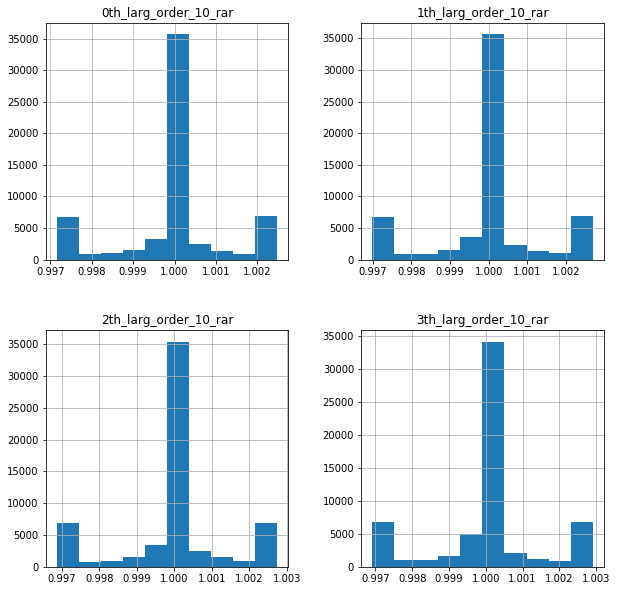

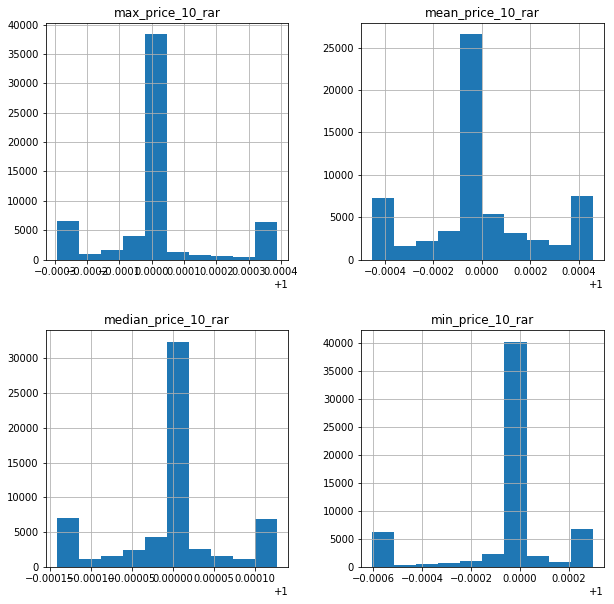

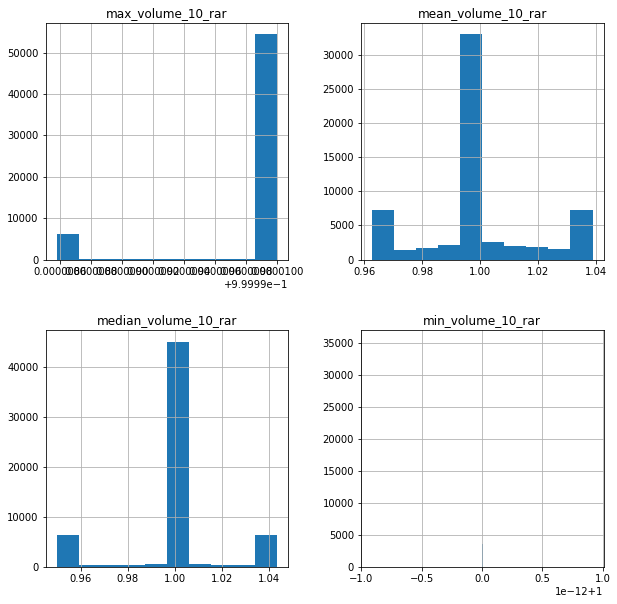

In [22]:
import numpy as np
import warnings

warnings.filterwarnings('ignore')

feature_categories_to_plot = ["_larg_order_10_rar", "_price_10_rar", "_volume_10_rar"]

for feature_category in feature_categories_to_plot:
    features_to_scan = sorted([h for h in data_df.columns.values if h.find(feature_category) != -1])[0:4]
    outliers_removed_df = data_df[features_to_scan].copy()
    outliers_removed_df.dropna(inplace=True)
    for feature_to_scan in features_to_scan:
        lower_bound = np.percentile(outliers_removed_df[feature_to_scan], 10)
        upper_bound = np.percentile(outliers_removed_df[feature_to_scan], 90)
        print(feature_to_scan, "lower_bound", lower_bound, "upper_bound", upper_bound)
        outliers_removed_df[feature_to_scan] = outliers_removed_df[feature_to_scan].map(lambda x: lower_bound if x < lower_bound
                                                                                        else upper_bound if x > upper_bound
                                                                                        else x)
    outliers_removed_df[features_to_scan].hist()

In [23]:
# some of the feature sets have very high correlations with other feature sets...
# this is a function that takes a feature set as a string tag and generates correlation matrices

import seaborn as sns

def generate_correlation_plot(feature_category_to_plot):
    correlation_df = data_df.copy()
    headers_to_plot = sorted([h for h in correlation_df.columns.values if h.find(feature_category_to_plot) != -1])
    correlation_df = correlation_df[headers_to_plot]
    correlation_df.dropna(inplace=True)
    corr = correlation_df.corr()
    sns.heatmap(corr,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

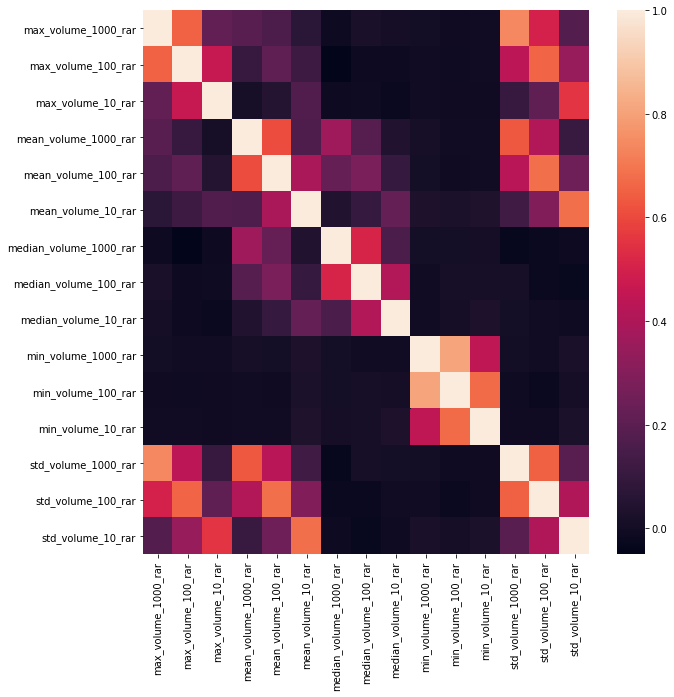

In [24]:
generate_correlation_plot("_volume_")

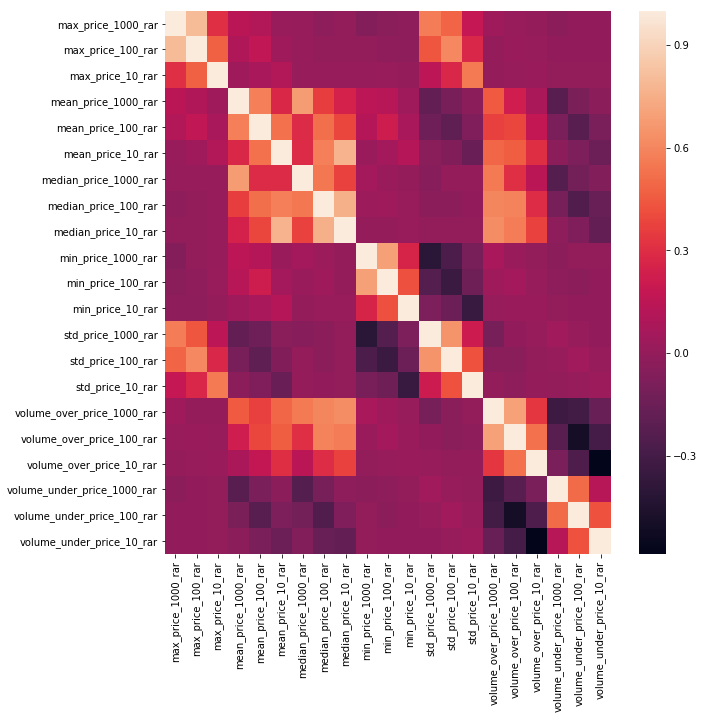

In [25]:
generate_correlation_plot("_price_")

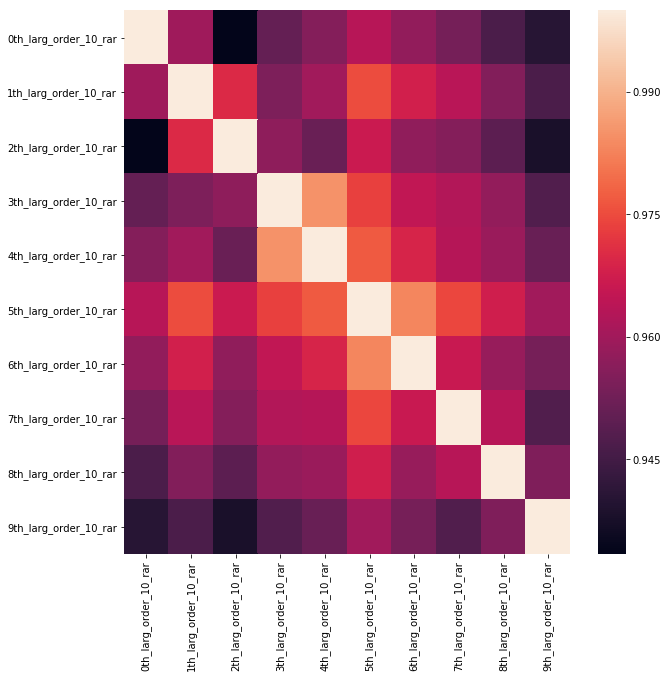

In [27]:
generate_correlation_plot("_larg_order_10_")